In [225]:
import pandas as pd
import json
from urllib.parse import quote
from urllib.request import urlopen
import re
import networkx as nx

To construct a list of french painters, and links to their corresponding wiki-pages, the wikipages containg a list of french painter is downloaded.

In [ ]:
URL_French_Painters='https://en.wikipedia.org/wiki/List_of_French_painters'

In [133]:
#create query for wikipage
title='titles=List_of_French_painters'
baseurl="https://en.wikipedia.org/w/api.php?"
action='action=query'
content="prop=revisions&rvprop=content"
dataformat="format=json"
query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)

#retive response
wikiresponse = urlopen(query)
wikidata = wikiresponse.read()
wikiPage = wikidata.decode('utf-8')
wiki_source=json.loads(wikiPage)

In [134]:
page=wiki_source['query']['pages']
page_id=next(iter(page))
page=page[page_id]['revisions'][0]['*']

We are only interested in the part of the page containing the list of painters. We therefor extract the text between the two headlines **alphabetically** and **See also**.

In [135]:
#regex=r'==alphabetically==([\s,\S]*?)== See also =='
regex=r'==alphabetically==([\s,\S]*?)== By century =='
page=re.findall(regex,page)[0]

Now that the relevant pages are identified the painters can be identified as links on the page.

In [136]:
regex_link='\[\[[^\]]*\]\]'
#regex_link='\[\[([^\[,\],\|]+)\|?([^\[,\],\|]*?)\]\]'

painters=re.findall(regex_link, page)

If a link has two values listed the first is the link, and the second is their name.

In [137]:
FrenchPainters=pd.DataFrame(painters,columns=['Links'])
FrenchPainters.head()

,Links
0,[[Edmond Aman-Jean]]
1,[[Albert André]]
2,[[Mathuren Arthur Andrieu]]
3,[[Gaston Anglade]]
4,[[Charles Angrand]]


In [138]:
regex_link='\[\[([^\[,\],\|]+)\|?([^\[,\],\|]*?)\]\]'
FrenchPainters['Divided_links']=FrenchPainters.Links.apply(lambda l: re.findall(regex_link, l))

In [139]:
FrenchPainters['wikiLinks']=FrenchPainters.Divided_links.apply(lambda l:l[0][0])

In [140]:
def extract_name(link):
    name=link[0][1]
    if name=='':
        name=link[0][0]
    return name

In [141]:
FrenchPainters['Name']=FrenchPainters.Divided_links.apply(lambda l:extract_name(l))

In [142]:
FrenchPainters=FrenchPainters.drop(['Links','Divided_links'],axis=1)

The list of painters with their corresponding wikilinks are now exported.

In [143]:
file = open('French_Painters.csv', "w",encoding='utf-8')
file.write(FrenchPainters.to_csv(index=False))
file.close()

Any duplicates are removed from the list.

In [151]:
FrenchPainters=FrenchPainters.drop_duplicates()

In [163]:
FrenchPainters.head()

,wikiLinks,Name
0,Edmond Aman-Jean,Edmond Aman-Jean
1,Albert André,Albert André
2,Mathuren Arthur Andrieu,Mathuren Arthur Andrieu
3,Gaston Anglade,Gaston Anglade
4,Charles Angrand,Charles Angrand


For each painter their corresponding wikipages are now downloaded.

In [175]:
def dowloadWikiPage(name,wikiLink,baseurl,action,content,dataformat):
    #Use API to send query for page
    quoted_link=quote(wikiLink)
    title = "titles={}".format(quoted_link)
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    wikiresponse = urlopen(query)
    wikidata = wikiresponse.read()
    wikiPage = wikidata.decode('utf-8')    
    wiki_source=json.loads(wikiPage)
    
    try:
        #Extract page content
        page=wiki_source['query']['pages']
        page_id=next(iter(page))
        page=page[page_id]['revisions'][0]['*']
    
        #Save page content in file
        file = open("FrenchPainters/"+name, "w",encoding='utf-8')
        file.write(page)
        file.close()
        return True
    # If page don't expect
    except:
        return False
        pass

In [176]:
has_page=[]
for index, row in FrenchPainters.iterrows():
    has_page.append(dowloadWikiPage(row['Name'],row['wikiLinks'],baseurl,action,content,dataformat))

In [171]:
for index, row in FrenchPainters.iterrows():
    dowloadWikiPage(row['Name'],row['wikiLinks'],baseurl,action,content,dataformat)

Jean-Claude Picot


In [177]:
FrenchPainters['downloaded']=has_page

c:\users\clara\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [189]:
FrenchPainters=FrenchPainters[FrenchPainters.downloaded]
FrenchPainters=FrenchPainters.drop('downloaded',axis=1)

A new csv file is now saved, storing the final painters, with corresponding pages.

In [190]:
file = open('French_Painters_clean.csv', "w",encoding='utf-8')
file.write(FrenchPainters.to_csv(index=False))
file.close()

To create an initial network, we now find links on each of the painters pages.

In [196]:
FrenchPainters=FrenchPainters.drop(['links','connections'],axis=1)

In [197]:
FrenchPainters['connections']=''

for index, row in FrenchPainters.iterrows():
    try:
        page_content=open('FrenchPainters/'+row['Name'],'r',encoding='utf-8').read()
        FrenchPainters.loc[index,'connections']=re.findall(regex_link,page_content)
    except:
        FrenchPainters.loc[index,'connections']=[]

In [199]:
FrenchPainters.head()

,wikiLinks,Name,connections
0,Edmond Aman-Jean,Edmond Aman-Jean,"[(Chevry-Cossigny, ), (Paris, ), (symbolist, )..."
1,Albert André,Albert André,"[(Post-Impressionist, ), (Pierre-Auguste Renoi..."
2,Mathuren Arthur Andrieu,Mathuren Arthur Andrieu,"[(Painting, painter), (portrait, ), (landscape..."
3,Gaston Anglade,Gaston Anglade,"[(impressionist, ), (Dordogne, ), (Pyrenées, )..."
4,Charles Angrand,Charles Angrand,"[(Criquetot-sur-Ouville, ), (Normandy, ), (Rou..."


In [202]:
FrenchPainters['Painter_links']=FrenchPainters.apply(lambda l: [connection[0] for connection in (l['connections'])if (connection[0]==FrenchPainters.wikiLinks).any()],axis=1)

In [220]:
print('number of connected french painters: ',len(FrenchPainters[FrenchPainters.Painter_links.astype(bool)]))

number of connected french painters:  193


In [221]:
print('number of french painters: ',len(FrenchPainters))

number of french painters:  352


In [227]:
FrenchPainters=FrenchPainters.set_index('Name')

In [229]:
FrenchPainters

,wikiLinks,connections,Painter_links
Name,,,
Edmond Aman-Jean,Edmond Aman-Jean,"[(Chevry-Cossigny, ), (Paris, ), (symbolist, )...","[Georges Seurat, Georges Seurat]"
Albert André,Albert André,"[(Post-Impressionist, ), (Pierre-Auguste Renoi...","[Pierre-Auguste Renoir, Claude Monet, Maurice ..."
Mathuren Arthur Andrieu,Mathuren Arthur Andrieu,"[(Painting, painter), (portrait, ), (landscape...",[]
Gaston Anglade,Gaston Anglade,"[(impressionist, ), (Dordogne, ), (Pyrenées, )...",[]
Charles Angrand,Charles Angrand,"[(Criquetot-sur-Ouville, ), (Normandy, ), (Rou...","[Jean-Baptiste-Camille Corot, Georges Seurat, ..."
...,...,...,...
Antoine Watteau,Antoine Watteau,"[(Rosalba Carriera, ), (Valenciennes, ), (Fran...","[François Boucher, Jean-Honoré Fragonard]"
François Willi Wendt,François Willi Wendt,"[(Berlin, ), (German Empire, Germany), (Hauts-...","[Pierre Soulages, Nicolas de Staël, Fernand Lé..."
Georges Yatridès,Georges Yatridès,"[(Grenoble, ), (Roybon, ), (Grenoble, ), (diss...",[]


We can now build a network

In [233]:
# initializing network
FrenchPainterNetwork=nx.DiGraph()

#adding a node for each painter
FrenchPainterNetwork.add_nodes_from(FrenchPainters.index)

#adding edges
for painter in FrenchPainterNetwork.nodes():
    for target in FrenchPainterNetwork.nodes():        
        #if painter links to target, then add edge from character node to target node
        if FrenchPainters.loc[target,'wikiLinks'] in FrenchPainters.loc[painter,'Painter_links']:
            FrenchPainterNetwork.add_edge(painter, target)

In [237]:
print('number of edges: ',len(FrenchPainterNetwork.edges()))

number of edges:  599


In [238]:
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
%matplotlib inline

In [239]:
forceatlas2 = ForceAtlas2()
positions = forceatlas2.forceatlas2_networkx_layout(FrenchPainterNetwork)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 188.77it/s]

BarnesHut Approximation  took  0.05  seconds
Repulsion forces  took  0.46  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds


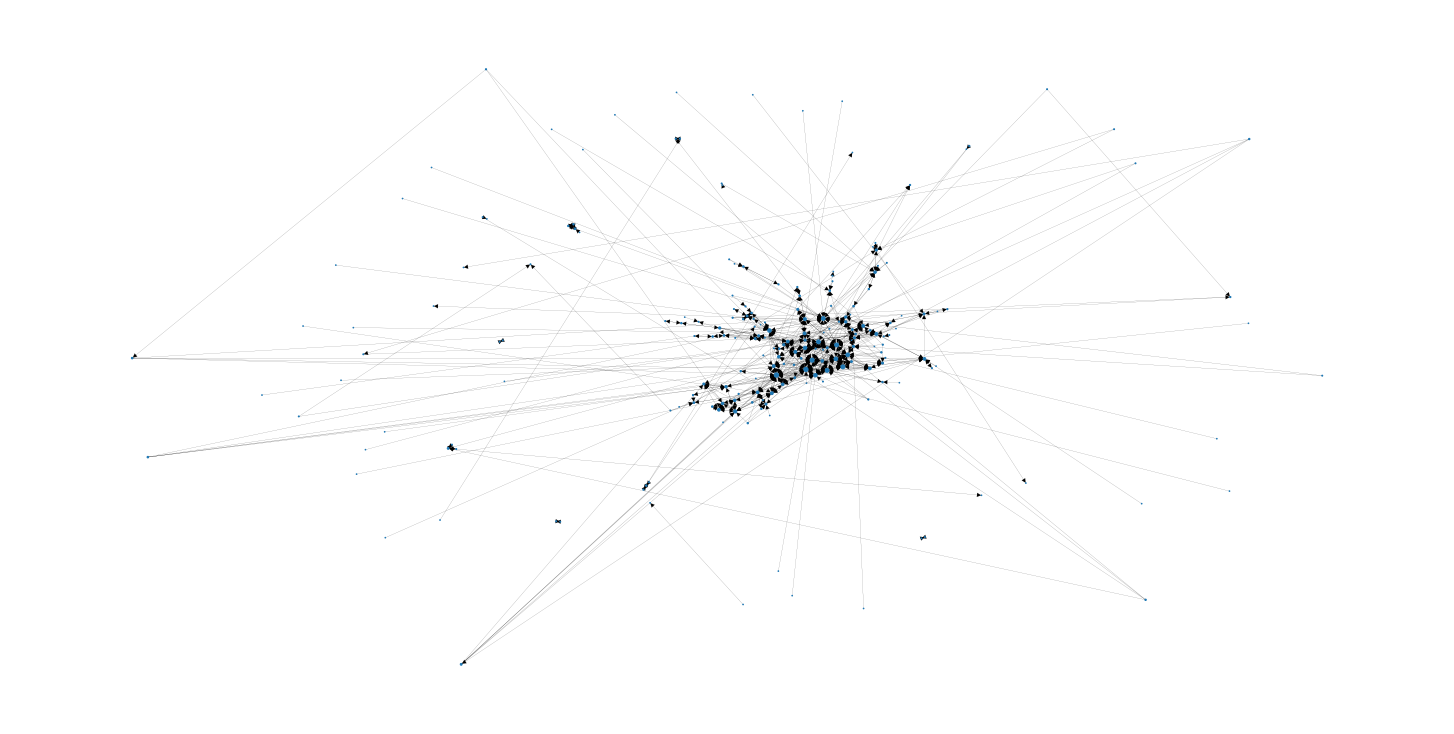

In [240]:
plt.figure(figsize=(20,10))
nx.draw(FrenchPainterNetwork,positions,node_size=[i[1]/2 for i in FrenchPainterNetwork.degree()],width=0.1)#,edge_color='#A0CBE2')
plt.show()